In [1]:
from keras.datasets import mnist 

# MNIST Load Normalization
(x_train, _), (x_test, _) = mnist.load_data()
y_train = x_train[:1000].astype('float32') / 255.
y_test = x_test.astype('float32') / 255. 

print(y_train.shape)
print(y_test.shape)

Using TensorFlow backend.


(1000, 28, 28)
(10000, 28, 28)


In [2]:
# conv2d input reshape (width*height*cannel)
y_train = y_train.reshape((y_train.shape[0],28,28,1))
y_test = y_test.reshape((y_test.shape[0],28,28,1))
print(y_train.shape)
print(y_test.shape)

(1000, 28, 28, 1)
(10000, 28, 28, 1)


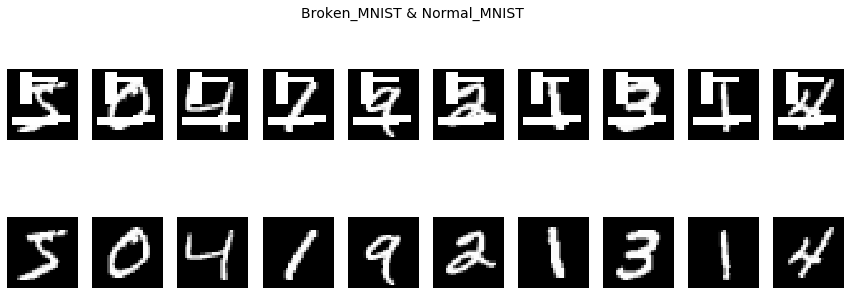

In [3]:
x_train = y_train.copy()
#x_train[: , 12:20 , :] = 1.
#x_train[: , 20:22 , :] = 1.

# cross fail_test_set
x_train[:,3:5,7:20] = 1.
x_train[:,1:14,5:10] = 1.

x_train[:,19:22,2:20] = 1.
x_train[:,18:21,16:25] = 1.



import matplotlib.pyplot as plt 

fig, axs = plt.subplots(2,10, figsize=(15, 5))
for i in range(10) :
    fig.suptitle('Broken_MNIST & Normal_MNIST', fontsize=14)
    axs[0, i].set_axis_off()
    axs[0, i].imshow(x_train[i].reshape(28,28), cmap='gray')
    axs[1, i].set_axis_off()
    axs[1, i].imshow(y_train[i].reshape(28,28), cmap='gray')
plt.show()
plt.close(fig)

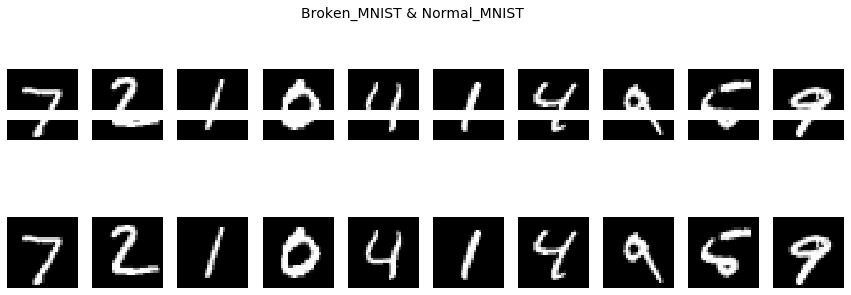

In [4]:
x_test = y_test.copy()
x_test[: , 16:20 , :] = 1.
#x_train[: , 20:22 , :] = 1.

import matplotlib.pyplot as plt 

fig, axs = plt.subplots(2,10, figsize=(15, 5))
for i in range(10) :
    fig.suptitle('Broken_MNIST & Normal_MNIST', fontsize=14)
    axs[0, i].set_axis_off()
    axs[0, i].imshow(x_test[i].reshape(28,28), cmap='gray')
    axs[1, i].set_axis_off()
    axs[1, i].imshow(y_test[i].reshape(28,28), cmap='gray')
plt.show()
plt.close(fig)

In [5]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def unet(input_size=(28,28,1)):
    inputs = Input(input_size)
    depth = 14

    conv1 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(depth*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(depth*4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    up1 = concatenate([Conv2DTranspose(depth*2, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
    dconv1 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(up1)
    dconv1 = BatchNormalization()(dconv1)
    dconv1 = Conv2D(depth*2, (3, 3), activation='relu', padding='same')(dconv1)
    dconv1 = BatchNormalization()(dconv1)

    up2 = concatenate([Conv2DTranspose(depth*1, (2, 2), strides=(2, 2), padding='same')(dconv1), conv1], axis=3)
    dconv2 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(up2)
    dconv2 = BatchNormalization()(dconv2)
    dconv2 = Conv2D(depth*1, (3, 3), activation='relu', padding='same')(dconv2)
    dconv2 = BatchNormalization()(dconv2)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(dconv2)
    return Model(inputs=[inputs], outputs=[outputs])

# 모델 생성
model = unet()

# 모델 컴파일
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 14)   140         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 14)   56          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 14)   1778        batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
# # ADDED START
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=10, # 0 ~ 180
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     fill_mode='nearest',
#     horizontal_flip=True,
#     vertical_flip=False 
# )
# # ADDED END

In [7]:
# # 데이터증강
# hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=1), epochs=10)

In [8]:
# 학습
hist = model.fit(x_train, y_train, validation_split=0.3, epochs=15, batch_size=3, verbose=1)

# 모델 저장
model.save('unet.h5')

Train on 700 samples, validate on 300 samples
Epoch 1/15
700/700 [==============================] - 4s 6ms/sample - loss: 0.2988 - accuracy: 0.7868 - val_loss: 0.2761 - val_accuracy: 0.7179
Epoch 2/15
700/700 [==============================] - 1s 2ms/sample - loss: 0.1207 - accuracy: 0.8180 - val_loss: 0.1146 - val_accuracy: 0.8024
Epoch 3/15
700/700 [==============================] - 1s 2ms/sample - loss: 0.0955 - accuracy: 0.8182 - val_loss: 0.0925 - val_accuracy: 0.8035
Epoch 4/15
700/700 [==============================] - 2s 2ms/sample - loss: 0.0867 - accuracy: 0.8182 - val_loss: 0.0832 - val_accuracy: 0.8050
Epoch 5/15
700/700 [==============================] - 2s 2ms/sample - loss: 0.0796 - accuracy: 0.8186 - val_loss: 0.0863 - val_accuracy: 0.8060
Epoch 6/15
700/700 [==============================] - 2s 2ms/sample - loss: 0.0760 - accuracy: 0.8187 - val_loss: 0.0777 - val_accuracy: 0.8048
Epoch 7/15
700/700 [==============================] - 2s 2ms/sample - loss: 0.0738 - accur

No handles with labels found to put in legend.


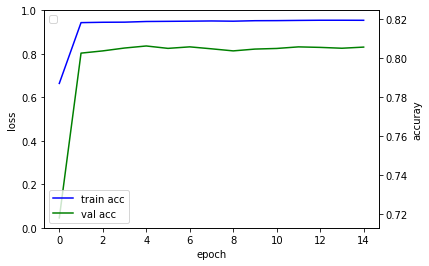

In [9]:

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
# loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
# acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
plt.close()

1/1 [==============================] - 0s 219ms/sample - loss: 0.0607 - accuracy: 0.8648


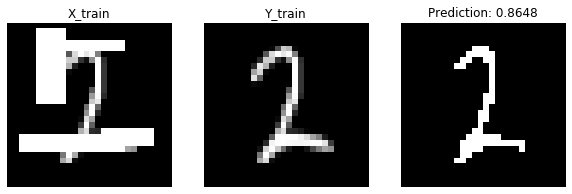

1/1 [==============================] - 0s 4ms/sample - loss: 0.3575 - accuracy: 0.6645


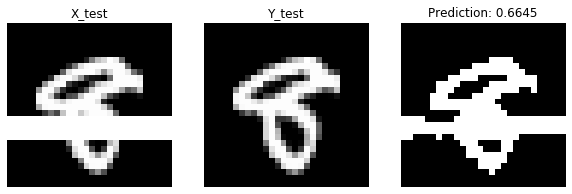

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plotPredictions(model, x_train, y_train, x_test, y_test):

    ix = np.random.randint(0, len(x_train))

    input_ = x_train[ix:ix+1]
    mask_ = y_train[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0].reshape((28,28)), 'gray')
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(x_test))
    input_ = x_test[ix:ix+1]
    mask_ = y_test[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0].reshape((28,28)), 'gray')
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()
    
plotPredictions(model, x_train, y_train, x_test, y_test)